In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import urllib.request 

import operator
from collections import Counter

### USE OpenCV KERNEL ###
import cv2
import numpy as np
from scipy.io import loadmat

from sklearn.decomposition import PCA
    
# default plot stying changes
import seaborn as sns
sns.set_style("white")
sns.set_context("poster", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
colors = sns.color_palette('Set2',12)

import warnings
warnings.filterwarnings('ignore')

# Download Data Sets

In [2]:
# if output directory doesn't exist, make it
orig_dir = 'original_data'
    
if not os.path.exists(orig_dir):
    os.makedirs(orig_dir)

# location and files for data sets from Stanford
base_url = 'http://ufldl.stanford.edu/housenumbers/'
train_file = 'train_32x32.mat'
test_file = 'test_32x32.mat'
extra_file = 'extra_32x32.mat'

files = [train_file, test_file, extra_file]

# download files if they do not exist
for file in files:
    if not os.path.isfile('{0}/{1}'.format(orig_dir, file)):
        _ = urllib.request.urlretrieve('{0}/{1}'.format(base_url, file), '{0}/{1}'.format(orig_dir, file))

# Load .mat Files into Memory

In [3]:
(26032/73257)*100

35.53517070041089

In [4]:
# limit number of data points
mod = 0.1 # percent
lim_train = round(73257*mod) #73,257total
lim_test = round(26032*mod) #26,032 total
lim_extra = 1 #531,131

# train data
train_data = loadmat(orig_dir+'/train_32x32.mat', variable_names='X').get('X')[:,:,:,:lim_train]
train_labels = loadmat(orig_dir+'/train_32x32.mat', variable_names='y').get('y')[:lim_train]

# test data
test_data = loadmat(orig_dir+'/test_32x32.mat', variable_names='X').get('X')[:,:,:,:lim_test]
test_labels = loadmat(orig_dir+'/test_32x32.mat', variable_names='y').get('y')[:lim_test]

# additional data for training
#extra_data = loadmat(orig_dir+'/extra_32x32.mat', variable_names='X').get('X')[:,:,:,:1]
#extra_labels = loadmat(orig_dir+'/extra_32x32.mat', variable_names='y').get('y')[:1]

In [5]:
print('Training data shape: {0} | Training labels shape: {1}'.format(train_data.shape, train_labels.shape))
print('Testing data shape:  {0}  | Testing labels shape:  {1}'.format(test_data.shape, test_labels.shape))
#print('Extra data shape:    {0}     | Extra labels shape:    {1}'.format(extra_data.shape, extra_labels.shape))

Training data shape: (32, 32, 3, 7326) | Training labels shape: (7326, 1)
Testing data shape:  (32, 32, 3, 2603)  | Testing labels shape:  (2603, 1)


# Distribution of Labels in Test and Train Datasets

In [6]:
# convert 10's to 0's
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

In [7]:
# get dictionary count of labels
train_lbl_lst = np.ravel(train_labels).tolist()
train_cnt_dict = dict(Counter(train_lbl_lst))

test_lbl_lst = np.ravel(test_labels).tolist()
test_cnt_dict = dict(Counter(test_lbl_lst))

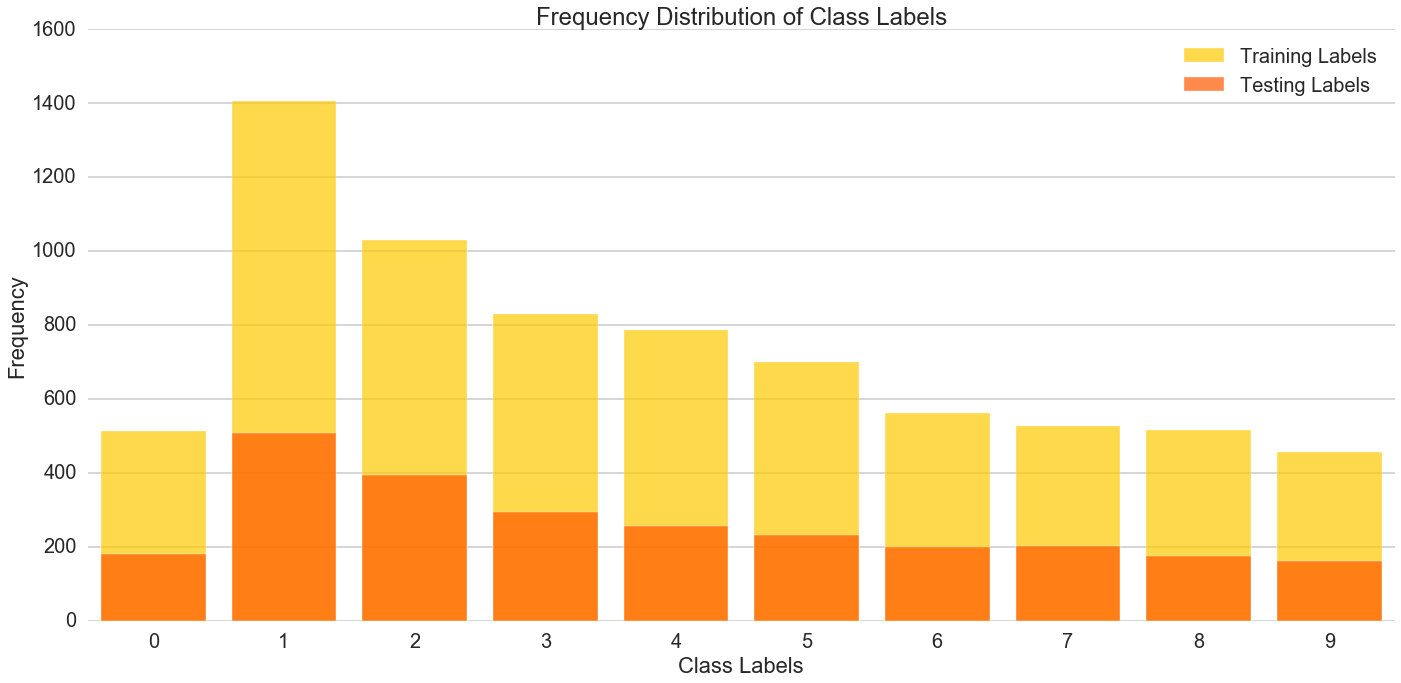

In [8]:
sns.set_palette("hot_r")
colors = sns.color_palette('hot_r',5)

# make figure
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# plots
plt.bar(range(len(train_cnt_dict)), train_cnt_dict.values(), align='center', color=colors[1], 
                alpha=0.7, edgecolor='w', label='Training Labels')
plt.bar(range(len(test_cnt_dict)), test_cnt_dict.values(), align='center', color=colors[2], 
                alpha=0.7, edgecolor='w', label='Testing Labels')

# labels/titles
plt.legend(loc="best")
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Class Labels')

plt.xlim(-0.5,9.5)
ticks = [0,1,2,3,4,5,6,7,8,9]
plt.xticks(ticks, ticks)

# remove border
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False)

# show grid
ax.yaxis.grid(True) 

# plot that biddy
plt.tight_layout()
_ = plt.show()

# Reshape Dataset

In [9]:
train_data = train_data.transpose((3,0,1,2))
test_data = test_data.transpose((3,0,1,2))
#extra_data = extra_data.transpose((3,0,1,2))

In [10]:
train_labels = np.ravel(train_labels)
test_labels = np.ravel(test_labels)
#extra_labels = np.ravel(extra_labels)

In [11]:
print('Training data shape: {0} | Training labels shape: {1}'.format(train_data.shape, train_labels.shape))
print('Testing data shape:  {0}  | Testing labels shape:  {1}'.format(test_data.shape, test_labels.shape))
#print('Extra data shape:    {0}     | Extra labels shape:    {1}'.format(extra_data.shape, extra_labels.shape))

Training data shape: (7326, 32, 32, 3) | Training labels shape: (7326,)
Testing data shape:  (2603, 32, 32, 3)  | Testing labels shape:  (2603,)


# Look at One Image

In [12]:
one_img = train_data[:,:,:,:][0]
one_img.shape

(32, 32, 3)

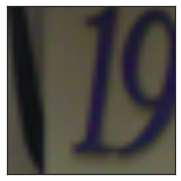

In [13]:
fig = plt.gcf()
fig.set_size_inches(3, 3)
plt.xticks([]),plt.yticks([])
_ = plt.imshow(one_img)

# Custom Conversion with Limited Number of Colors

In [14]:
def gray_conv(image, num_shades):
    '''
    input: image array(h,w), and number of desired gray shades
    output: list of converted rgb values
    '''
    if num_shades < 255 or num_shades > 2:
        x, y, _ = image.shape
        gray = []
        
        for i in range(x):
            for j in range(y):
                conv = 255 / (num_shades - 1)
                avg = (sum(image[i][j])) / 3
                gray.append(int(int(round(avg / conv)) * conv))
    return np.array(gray)

In [15]:
def img_arr_conv(lst,row,col):
    '''
    ONLY NEEDED FOR VIEWING IMAGES - NOT ANALYSIS
    input: list with desired image height(row) and width(col)
    output: image in the form of ndarray(col,row)
    '''
    result = np.array(lst)
    result = np.ndarray.reshape(result, (row,col))
        
    return result

In [16]:
def conv_CustGray_2d_arr(img_arr, col_l, col_r, num_shades):
    '''
    input: array of images as ndarray, left col start and right col end for image slicing
            and number of gray shade limit
    output: ndarray of ndarrays (images, pixels) with limited number of greyscale values
    '''
    num_imgs, _, _, _ = img_arr.shape
    
    arr_2d = []
    
    for i in range(num_imgs):
        img = img_arr[:,:,:,:][i]
        img_trim = img[:, col_l:col_r]
        
        gray_img = gray_conv(img_trim, num_shades)
        
        arr_2d.append(gray_img)
    
    return np.asarray(arr_2d)

# Demo of Custom Conversion

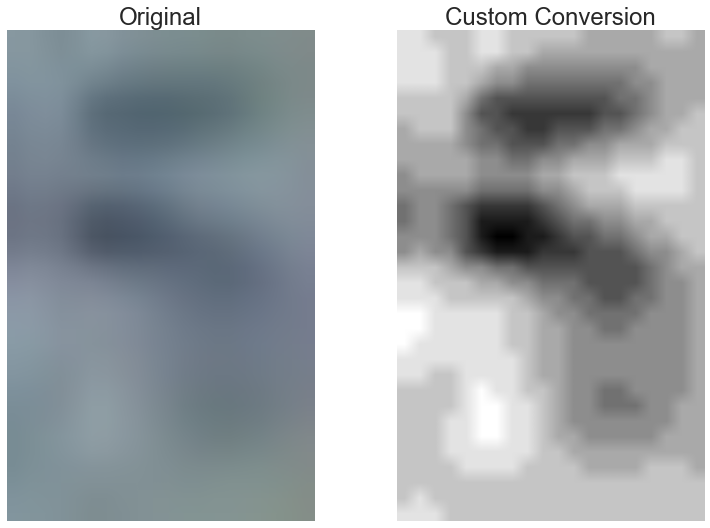

In [17]:
img_num = 5
shades = 32

orig_img = train_data[:,:,:,:][img_num]
orig_img = orig_img[:,6:26]
scaled_img = img_arr_conv(gray_conv(orig_img, shades), 32, 20)

titles = ['Original', 'Custom Conversion']
images = [orig_img, scaled_img]

fig.set_size_inches(3, 3)
for i in range(2):
    plt.subplot(1,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.axis('off')
    plt.xticks([]),plt.yticks([])
plt.show()

# OpenCV Thresholds

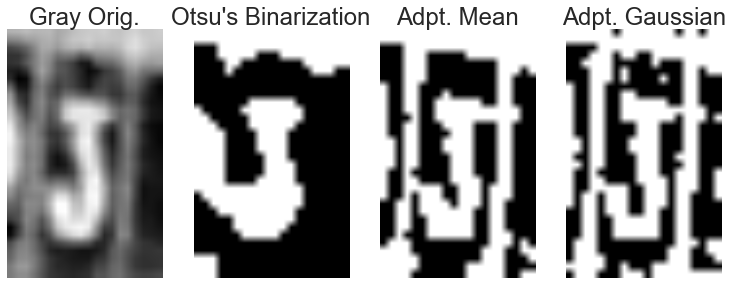

In [31]:
select_img = 7
block_sz = 7
const = 2 # subtracted from the mean or weighted mean calculated

# original image
img = train_data[:,:,:,:][select_img]
img = img[:,6:26]
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Otsus Binariziation 
blur = cv2.GaussianBlur(img,(5,5),0)
ret, th1 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Adaptive mean
th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_sz, const)

# Adaptive Gaussian
th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_sz, const)

titles = ['Gray Orig.', 'Otsu\'s Binarization', 'Adpt. Mean', 'Adpt. Gaussian']
images = [img, th1, th2, th3]

fig.set_size_inches(12, 6)
for i in range(4):
    
    plt.subplot(1,4,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.axis('off')
    plt.xticks([]),plt.yticks([])
plt.show()

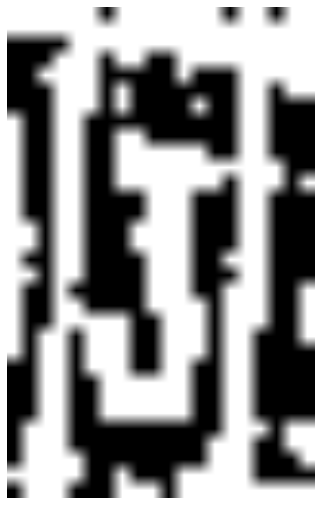

In [33]:
plt.imshow(th3,'gray')
plt.axis('off')
plt.xticks([]),plt.yticks([])
plt.savefig('imgs/agt_7.png', bbox_inches='tight')

# Otsu's Binarization Thresholding

In [34]:
def conv_OBT_2d_arr(img_arr, col_l, col_r, block_size):
    '''
    input: array of images as ndarray, left col start and right col end for image slicing
    output: ndarray of ndarrays (images, pixels) thresholded using Otsu's binarization thresholding
    source: http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html#gsc.tab=0
    '''
    num_imgs, _, _, _ = img_arr.shape
    
    arr_2d = []
    
    for i in range(num_imgs):
        # grab individual image
        img = img_arr[:,:,:,:][i]
        
        # convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        # trim width (focus on digit)
        img = img[:, col_l:col_r]
        
        # make sure the blur block size is odd
        if block_size % 2 == 0:
            block_size += 1
            
        # Otsus Binariziation
        blur = cv2.GaussianBlur(img,(block_size,block_size),0)
            
        _, img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        arr_2d.append(np.ravel(img))
    
    return np.asarray(arr_2d)

# Adaptive Mean Thresholding

In [35]:
def conv_AMT_2d_arr(img_arr, col_l, col_r, block_size, const):
    '''
    input: array of images as ndarray, left col start and right col end for image slicing
    output: ndarray of ndarrays (images, pixels) thresholded using adaptive mean
    source: http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html#gsc.tab=0
    '''
    num_imgs, _, _, _ = img_arr.shape
    
    arr_2d = []
    
    for i in range(num_imgs):
        # grab individual image
        img = img_arr[:,:,:,:][i]
        
        # convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        # trim width (focus on digit)
        img = img[:, col_l:col_r]
        
        # make sure the blur block size is odd
        if block_size % 2 == 0:
            block_size += 1
            
        # Adaptive mean
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, const)
        
        arr_2d.append(np.ravel(img))
    
    return np.asarray(arr_2d)

# Adaptive Gausian Thresholding

In [36]:
def conv_AGT_2d_arr(img_arr, col_l, col_r, block_size, const):
    '''
    input: array of images as ndarray, left col start and right col end for image slicing
    output: ndarray of ndarrays (images, pixels) thresholded using adaptive Gausian
    source: http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html#gsc.tab=0
    '''
    num_imgs, _, _, _ = img_arr.shape
    
    arr_2d = []
    
    for i in range(num_imgs):
        # grab individual image
        img = img_arr[:,:,:,:][i]
        
        # convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        # trim width (focus on digit)
        img = img[:, col_l:col_r]
        
        # make sure the blur block size is odd
        if block_size % 2 == 0:
            block_size += 1
            
        # Adaptive Gaussian
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, const)
        
        arr_2d.append(np.ravel(img))
    
    return np.asarray(arr_2d)

# PCA Transformation

In [37]:
def conv_PCA_2d_arr(img_arr, col_l, col_r, numb_components):
    '''
    input: array of images as ndarray, left col start and right col end for image slicing and number of components
    output: ndarray of ndarrays (images, pixels) flattened using PCA to limited number of colors
    source: https://medium.com/@dimart/pok%C3%A9mon-recognition-d3ad5cadc61e#.whsqst6us
    '''
    num_imgs, _, _, _ = img_arr.shape
    
    arr_2d = []
    
    for i in range(num_imgs):
        # grab individual image
        img = img_arr[:,:,:,:][i]
        
        # convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        # trim width (focus on digit)
        img = img[:, col_l:col_r]
        
        arr_2d.append(np.ravel(img))
    
    # converted images into 2d grayscale
    arr_2d = np.asarray(arr_2d)
    
    # apply principal component analysis
    pca = PCA(n_components=numb_components, whiten=True).fit(arr_2d)
    pca_arr = pca.transform(arr_2d)
    
    return pca_arr

# Pickle Numpy Arrays (Output Processed Data)

In [38]:
# if output directory doesn't exist, make it
output_directory = 'generated_data'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

## Custom Conversion Output

In [24]:
cl, cr = 6, 26
ns = 7 # number of shades

train_f = 'train_CustGray_2d.dat'
test_f = 'test_CustGray_2d.dat'

# remove existing files if they exist
try:
    os.remove(train_f)
    os.remove(test_f)
except OSError:
    pass

train_CustGray_arr = conv_CustGray_2d_arr(train_data, col_l=cl, col_r=cr, num_shades=ns)
train_CustGray_arr.dump('{0}/{1}'.format(output_directory, train_f))
              
test_CustGray_arr = conv_CustGray_2d_arr(test_data, col_l=cl, col_r=cr, num_shades=ns)
test_CustGray_arr.dump('{0}/{1}'.format(output_directory, test_f))

In [25]:
print(train_CustGray_arr.shape)
print(test_CustGray_arr.shape)

(7326, 640)
(2603, 640)


## Otsu's Binarization Thresholding Output

In [26]:
cl, cr = 6, 26
bs = 7 # block size

train_f = 'train_OBT_2d.dat'
test_f = 'test_OBT_2d.dat'

# remove existing files if they exist
try:
    os.remove(train_f)
    os.remove(test_f)
except OSError:
    pass

train_OBT_arr = conv_OBT_2d_arr(train_data, col_l=cl, col_r=cr, block_size=bs)
train_OBT_arr.dump('{0}/{1}'.format(output_directory, train_f))

test_OBT_arr = conv_OBT_2d_arr(test_data, col_l=cl, col_r=cr, block_size=bs)
test_OBT_arr.dump('{0}/{1}'.format(output_directory, test_f))

In [27]:
print(train_OBT_arr.shape)
print(test_OBT_arr.shape)

(7326, 640)
(2603, 640)


## Adaptive Mean Thresholding Output

In [28]:
cl, cr = 6, 26
bs = 7 # block size
c = 2 # constant

train_f = 'train_AMT_2d.dat'
test_f = 'test_AMT_2d.dat'

# remove existing files if they exist
try:
    os.remove(train_f)
    os.remove(test_f)
except OSError:
    pass

train_AMT_arr = conv_AMT_2d_arr(train_data, col_l=cl, col_r=cr, block_size=bs, const=c)
train_AMT_arr.dump('{0}/{1}'.format(output_directory, train_f))

test_AMT_arr = conv_AMT_2d_arr(test_data, col_l=cl, col_r=cr, block_size=bs, const=c)
test_AMT_arr.dump('{0}/{1}'.format(output_directory, test_f))

In [29]:
print(train_AMT_arr.shape)
print(test_AMT_arr.shape)

(7326, 640)
(2603, 640)


## Adaptive Gaussian Thresholding Output

In [30]:
cl, cr = 6, 26
bs = 7 # block size
c = 2 # constant

train_f = 'train_AGT_2d.dat'
test_f = 'test_AGT_2d.dat'

# remove existing files if they exist
try:
    os.remove(train_f)
    os.remove(test_f)
except OSError:
    pass

train_AGT_arr = conv_AGT_2d_arr(train_data, col_l=cl, col_r=cr, block_size=bs, const=c)
train_AGT_arr.dump('{0}/{1}'.format(output_directory, train_f))

test_AGT_arr = conv_AGT_2d_arr(test_data, col_l=cl, col_r=cr, block_size=bs, const=c)
test_AGT_arr.dump('{0}/{1}'.format(output_directory, test_f))

In [31]:
print(train_AGT_arr.shape)
print(test_AGT_arr.shape)

(7326, 640)
(2603, 640)


## Principle Component Analysis Output

In [66]:
cl, cr = 6, 26
nc = 40 # number of components

train_f = 'train_PCA_2d.dat'
test_f = 'test_PCA_2d.dat'

# remove existing files if they exist
try:
    os.remove(train_f)
    os.remove(test_f)
except OSError:
    pass

train_PCA_arr = conv_PCA_2d_arr(train_data, col_l=cl, col_r=cr, numb_components=nc)
train_PCA_arr.dump('{0}/{1}'.format(output_directory, train_f))

test_PCA_arr = conv_PCA_2d_arr(test_data, col_l=cl, col_r=cr, numb_components=nc)
test_PCA_arr.dump('{0}/{1}'.format(output_directory, test_f))

In [67]:
print(train_PCA_arr.shape)
print(test_PCA_arr.shape)

(7326, 40)
(2603, 40)


## Label Output

In [34]:
def pickle_labels(arr, directory, filename):
    arr.dump('{0}/{1}'.format(directory,filename))

train_f = 'train_labels.dat'
test_f = 'test_labels.dat'

# remove existing files if they exist
try:
    os.remove(train_f)
    os.remove(test_f)
except OSError:
    pass

# output to pickle files
pickle_labels(train_labels, output_directory, train_f)
pickle_labels(test_labels, output_directory, test_f)

In [35]:
print(train_labels.shape)
print(test_labels.shape)

(7326,)
(2603,)


# Demo of PCA

In [39]:
exp = []
for i in range(1000):
    orig_img = train_data[:,:,:,:][i]
    scaled_img = img_arr_conv(gray_conv(orig_img, 255), 32, 32)
    scaled_img = scaled_img[:,6:26]
    exp.append(scaled_img)

exp = np.asarray(exp)
exp = np.ndarray.reshape(exp, (1000,640))
exp.shape

(1000, 640)

In [40]:
# Apply PCA
h, w = 32, 20
n_components = 200

pca = PCA(n_components=n_components, whiten=True).fit(exp)
train_pca = pca.transform(exp)

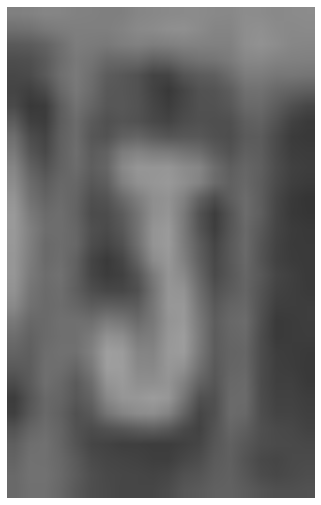

In [45]:
from PIL import Image
reconstruction = pca.inverse_transform(train_pca[7])
im = Image.fromarray(reconstruction.reshape(h,w))

plt.imshow(im, cmap='Greys_r')
plt.axis('off')
_ = plt.show

plt.imshow(im,'gray')
plt.axis('off')
plt.xticks([]),plt.yticks([])
plt.savefig('imgs/pca_7.png', bbox_inches='tight')